In [1]:
import os
import glob
import random

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


learning_rate = 0.001
batch_size = 10
epochs = 10


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [4]:
train_path = '/Users/vadimkotlarskij/Desktop/Python/Lab2/datasetlab5/train'
test_path = '/Users/vadimkotlarskij/Desktop/Python/Lab2/datasetlab5/test'
val_path = '/Users/vadimkotlarskij/Desktop/Python/Lab2/datasetlab5/val'

path1 = "annotation_tiger.csv"
path2 = "annotation_leopard.csv"
dfs = []
tmp = pd.read_csv(path1, sep=',', header=None)
dfs.append(tmp)
tmp = pd.read_csv(path2, sep=',', header=None)
dfs.append(tmp)
df = pd.concat(dfs)
df.drop(1, axis=1, inplace=True)
df.rename(columns={0: 'absolute_way', 2: 'class_img'}, inplace=True)
df.reset_index(inplace=True)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)



def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    dowload img from dataframe with path
    '''
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.class_img[i]}.{i}.jpg'), image)


def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    dowload img from dataframe with path
    '''
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    dowload img from dataframe with path, work with separation 80:10:10
    '''
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    # if i - 768 > 95:
    #     i = i - 1632
    # else:
    #     i = i - 768
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


# using
for i in range(768):
    load_train(df, train_path, i)
for i in range(961,1729):
    load_train(df, train_path, i)
for i in range(768,865):
    load_test(df,test_path,i)
for i in range(1729,1826):
    load_test(df,test_path,i)
for i in range(865,960):
    load_val(df,val_path,i)
for i in range(1826,1920):
    load_val(df,val_path,i)
# for i in range(97, 1537):
#     load_train(df, val_path, i)
#
# for i in range(1537, 1921):
#     load_val(df, val_path, i)

#for i in range(97):
# for i in range(1890, 1920):
#     load_test(df, val_path, i)

# for i in range(1995, 2100):
#     load_train(df, val_path, i)


train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
val_list = glob.glob(os.path.join(val_path, '*.jpg'))

# split our data into train and test sets
train_list, val_list = train_test_split(train_list, test_size=0.1)

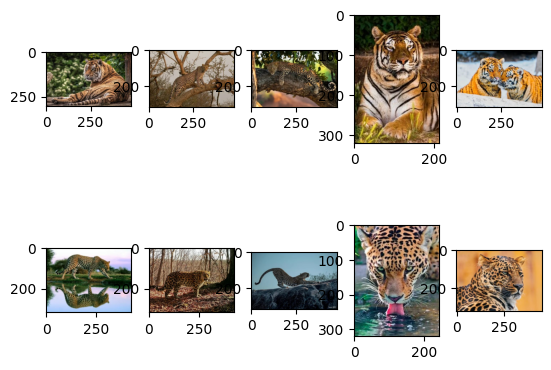

In [5]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [8]:
from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'tiger':
            label = 1
        elif label == 'leopard':
            label = 0

        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

Learning rate: 0.001, Batch size: 10
Epoch : 1, train accuracy : 0.635252058506012, train loss : 0.6315615177154541
Epoch : 1, val_accuracy : 0.746874988079071, val_loss : 0.5183076858520508
Epoch : 2, train accuracy : 0.7467626929283142, train loss : 0.5077982544898987
Epoch : 2, val_accuracy : 0.793749988079071, val_loss : 0.45418697595596313
Epoch : 3, train accuracy : 0.7884892225265503, train loss : 0.44461899995803833
Epoch : 3, val_accuracy : 0.824999988079071, val_loss : 0.39705872535705566
Epoch : 4, train accuracy : 0.8151081800460815, train loss : 0.40499308705329895
Epoch : 4, val_accuracy : 0.800000011920929, val_loss : 0.44746142625808716
Epoch : 5, train accuracy : 0.8287772536277771, train loss : 0.40950170159339905
Epoch : 5, val_accuracy : 0.8531249761581421, val_loss : 0.3836175203323364
Epoch : 6, train accuracy : 0.8453238606452942, train loss : 0.34287184476852417
Epoch : 6, val_accuracy : 0.8812500238418579, val_loss : 0.28424692153930664
Epoch : 7, train accurac

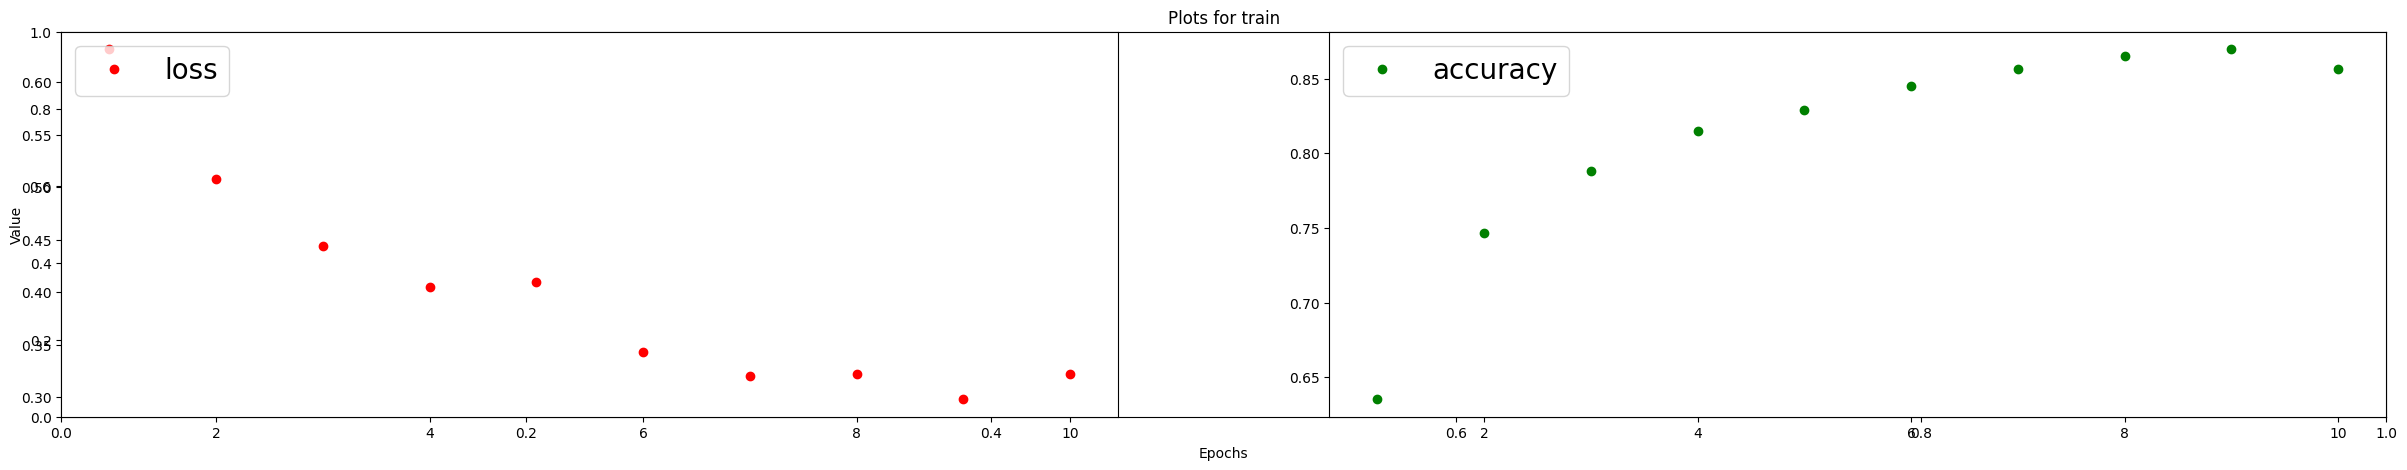

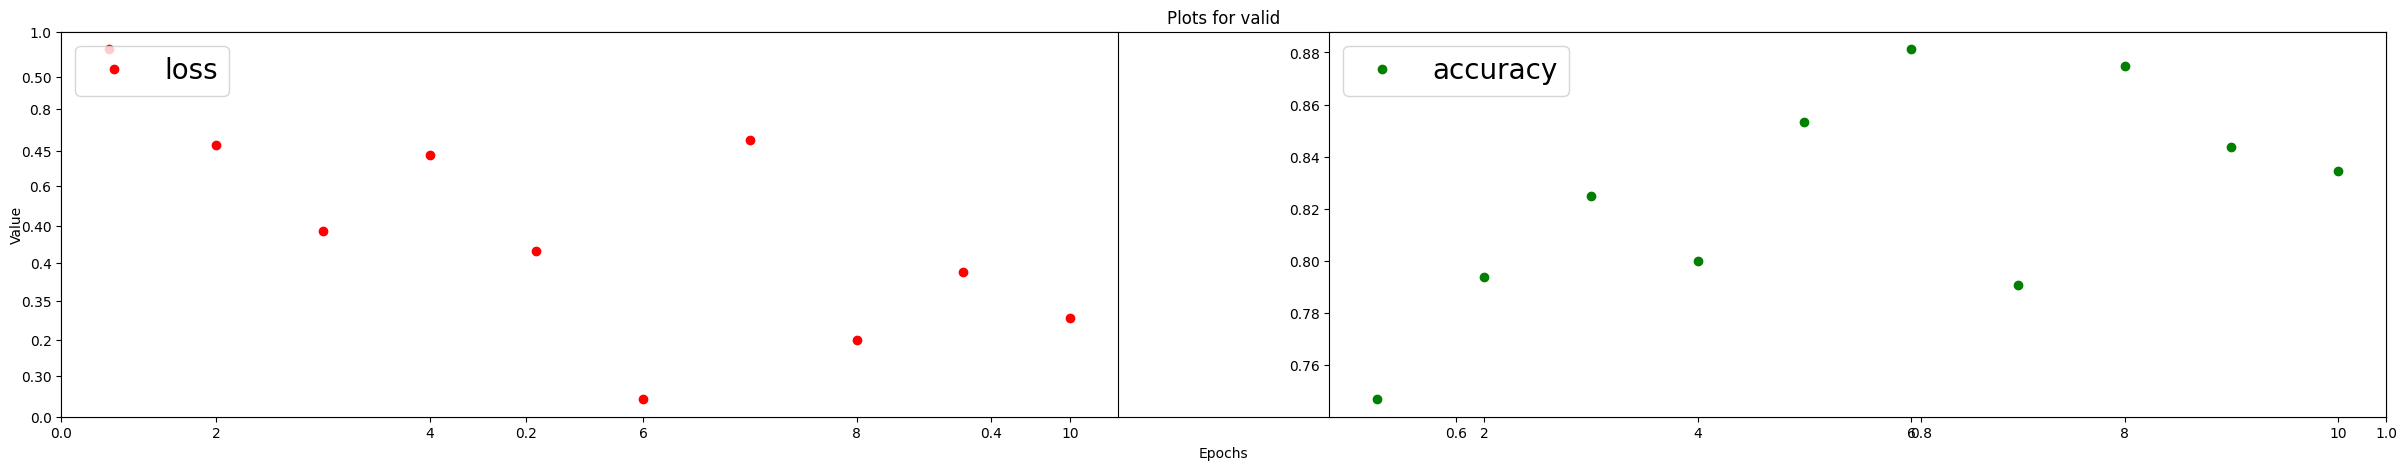

In [9]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 10
def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output,label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)


            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))


    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, val_accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10
Epoch : 1, train accuracy : 0.8985605835914612, train loss : 0.2471853494644165
Epoch : 1, val_accuracy : 0.828125, val_loss : 0.3533904552459717
Epoch : 2, train accuracy : 0.8971218466758728, train loss : 0.23464058339595795
Epoch : 2, val_accuracy : 0.9062498807907104, val_loss : 0.22209979593753815
Epoch : 3, train accuracy : 0.9115102887153625, train loss : 0.21228212118148804
Epoch : 3, val_accuracy : 0.8906249403953552, val_loss : 0.2228884994983673
Epoch : 4, train accuracy : 0.8964022994041443, train loss : 0.23821963369846344
Epoch : 4, val_accuracy : 0.9312499761581421, val_loss : 0.17235730588436127
Epoch : 5, train accuracy : 0.916546106338501, train loss : 0.21048007905483246
Epoch : 5, val_accuracy : 0.8781249523162842, val_loss : 0.2417943775653839
Epoch : 6, train accuracy : 0.9028770923614502, train loss : 0.2148483246564865
Epoch : 6, val_accuracy : 0.9312499761581421, val_loss : 0.18832366168498993
Epoch : 7, train accuracy : 0.

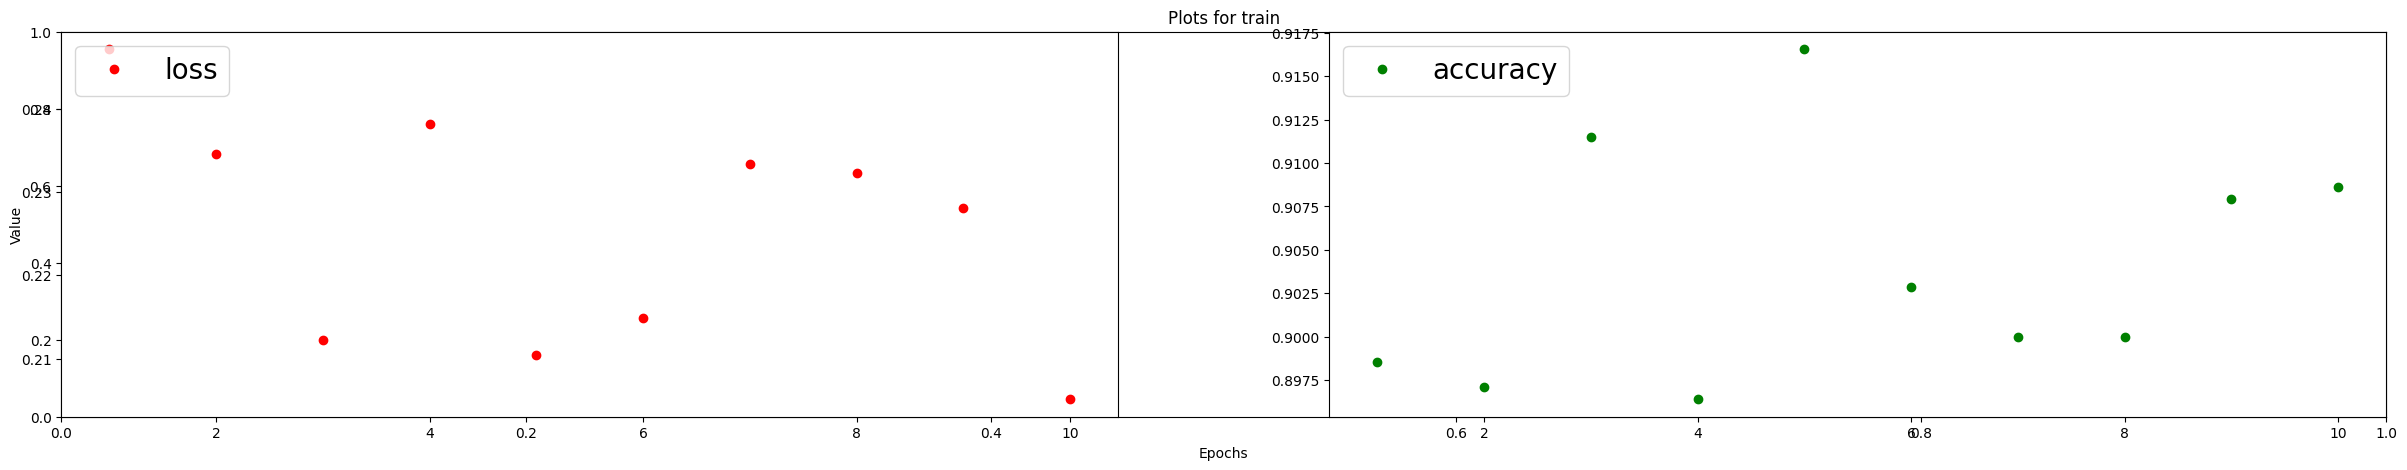

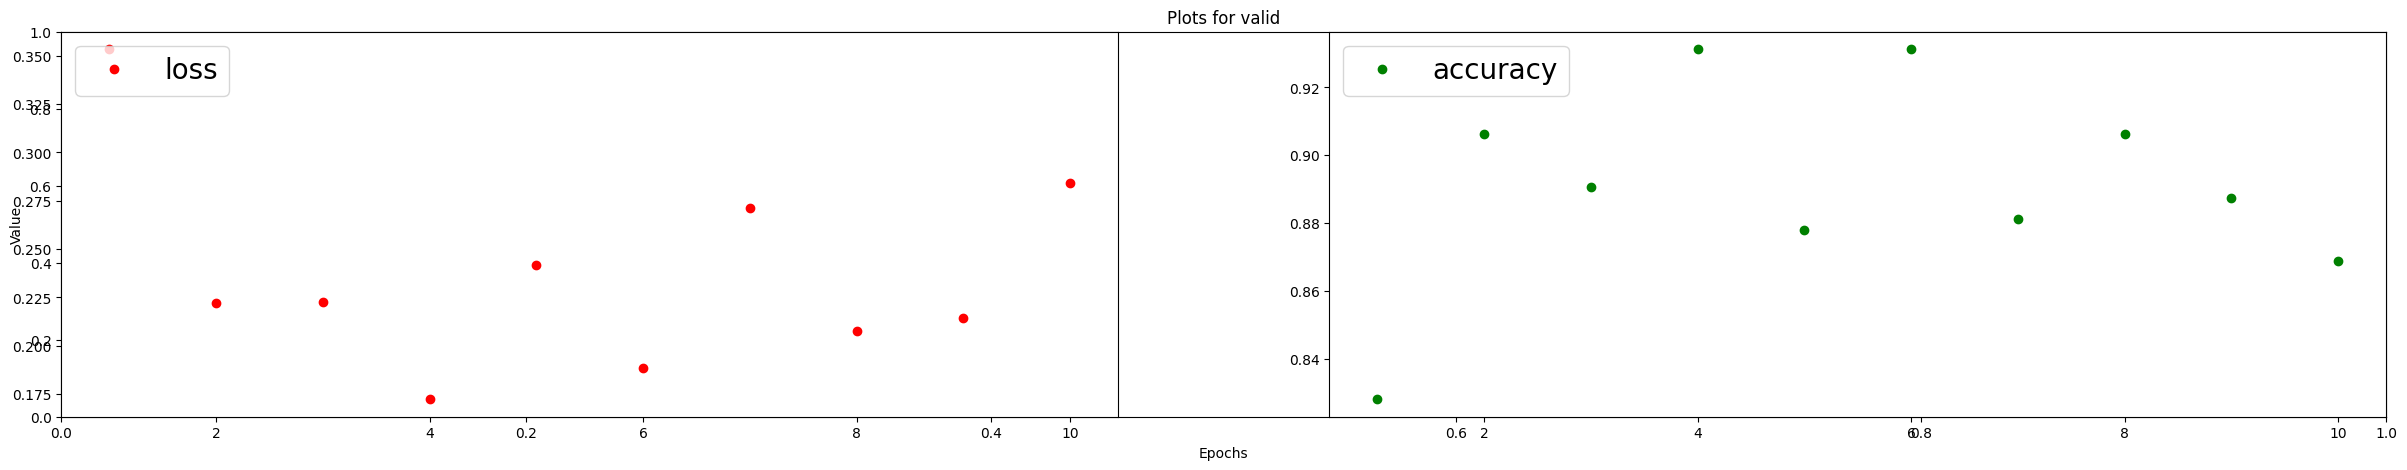

In [10]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10
Epoch : 1, train accuracy : 0.9251793026924133, train loss : 0.19283516705036163
Epoch : 1, val_accuracy : 0.878125011920929, val_loss : 0.3001145124435425
Epoch : 2, train accuracy : 0.9244595170021057, train loss : 0.18820804357528687
Epoch : 2, val_accuracy : 0.9218749403953552, val_loss : 0.1901225745677948
Epoch : 3, train accuracy : 0.9143880009651184, train loss : 0.21038047969341278
Epoch : 3, val_accuracy : 0.8749999403953552, val_loss : 0.39669907093048096
Epoch : 4, train accuracy : 0.9172655344009399, train loss : 0.20073319971561432
Epoch : 4, val_accuracy : 0.90625, val_loss : 0.24616187810897827
Epoch : 5, train accuracy : 0.9115099310874939, train loss : 0.20781120657920837
Epoch : 5, val_accuracy : 0.8843749165534973, val_loss : 0.24193942546844482
Epoch : 6, train accuracy : 0.9035966992378235, train loss : 0.2173498272895813
Epoch : 6, val_accuracy : 0.921875, val_loss : 0.22642743587493896
Epoch : 7, train accuracy : 0.913668453

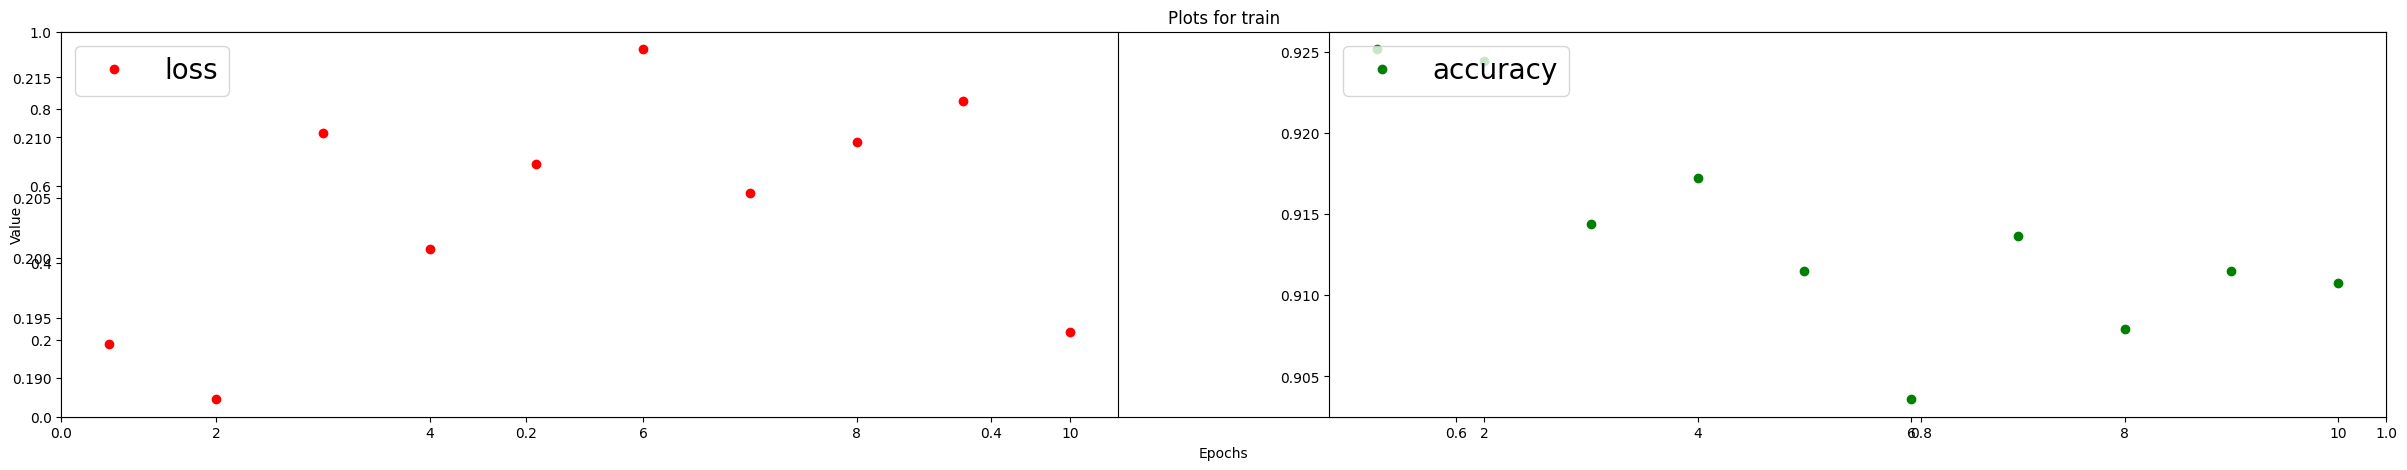

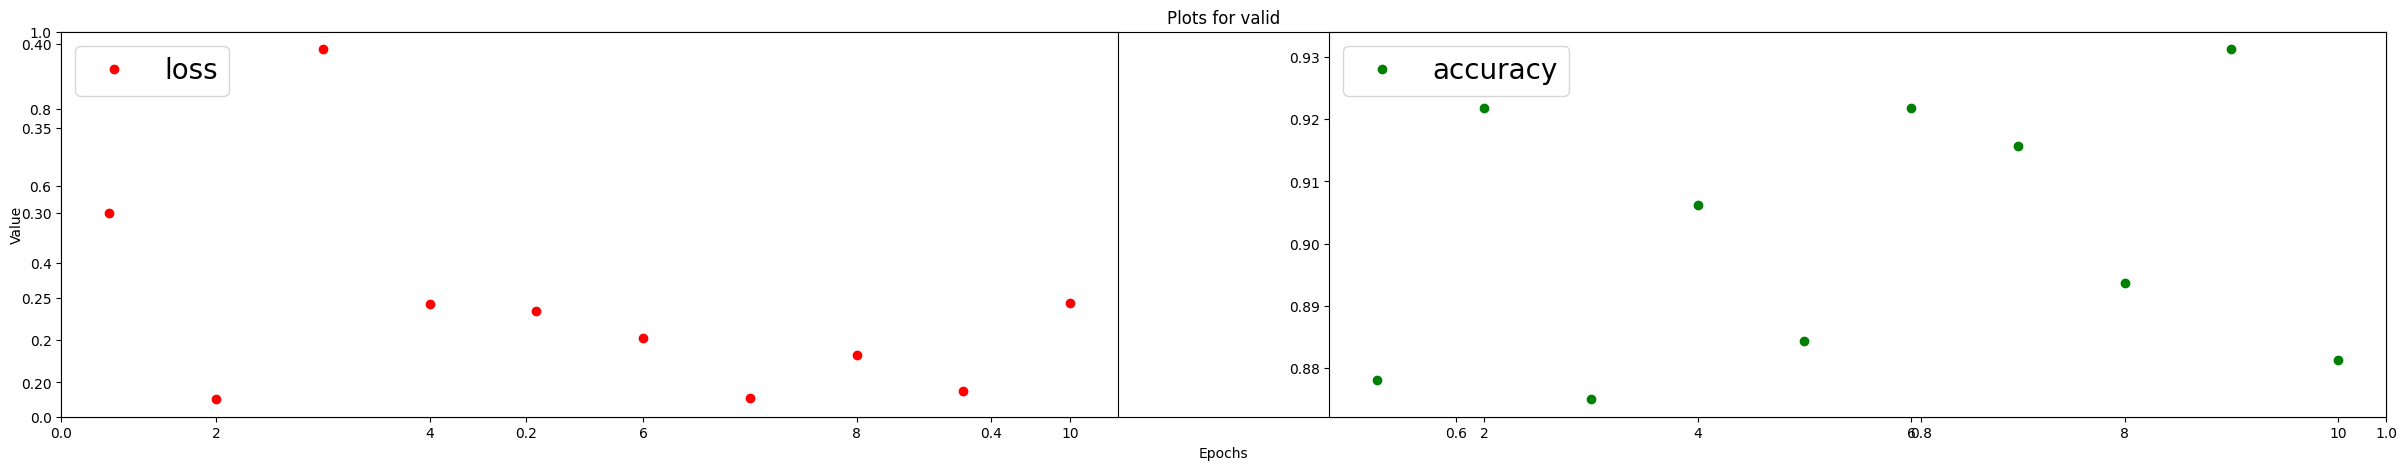

In [11]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20
Epoch : 1, train accuracy : 0.923571765422821, train loss : 0.17943261563777924
Epoch : 1, val_accuracy : 0.90625, val_loss : 0.22096329927444458
Epoch : 2, train accuracy : 0.9378575086593628, train loss : 0.14743724465370178
Epoch : 2, val_accuracy : 0.949999988079071, val_loss : 0.15412969887256622
Epoch : 3, train accuracy : 0.9400004744529724, train loss : 0.1487896889448166
Epoch : 3, val_accuracy : 0.9357142448425293, val_loss : 0.15106910467147827
Epoch : 4, train accuracy : 0.9407148361206055, train loss : 0.15889088809490204
Epoch : 4, val_accuracy : 0.928571343421936, val_loss : 0.15941131114959717
Epoch : 5, train accuracy : 0.9250004887580872, train loss : 0.17894120514392853
Epoch : 5, val_accuracy : 0.9499999284744263, val_loss : 0.12422111630439758
Epoch : 6, train accuracy : 0.9378575682640076, train loss : 0.1611921191215515
Epoch : 6, val_accuracy : 0.9624999761581421, val_loss : 0.11435461044311523
Epoch : 7, train accuracy : 0.9

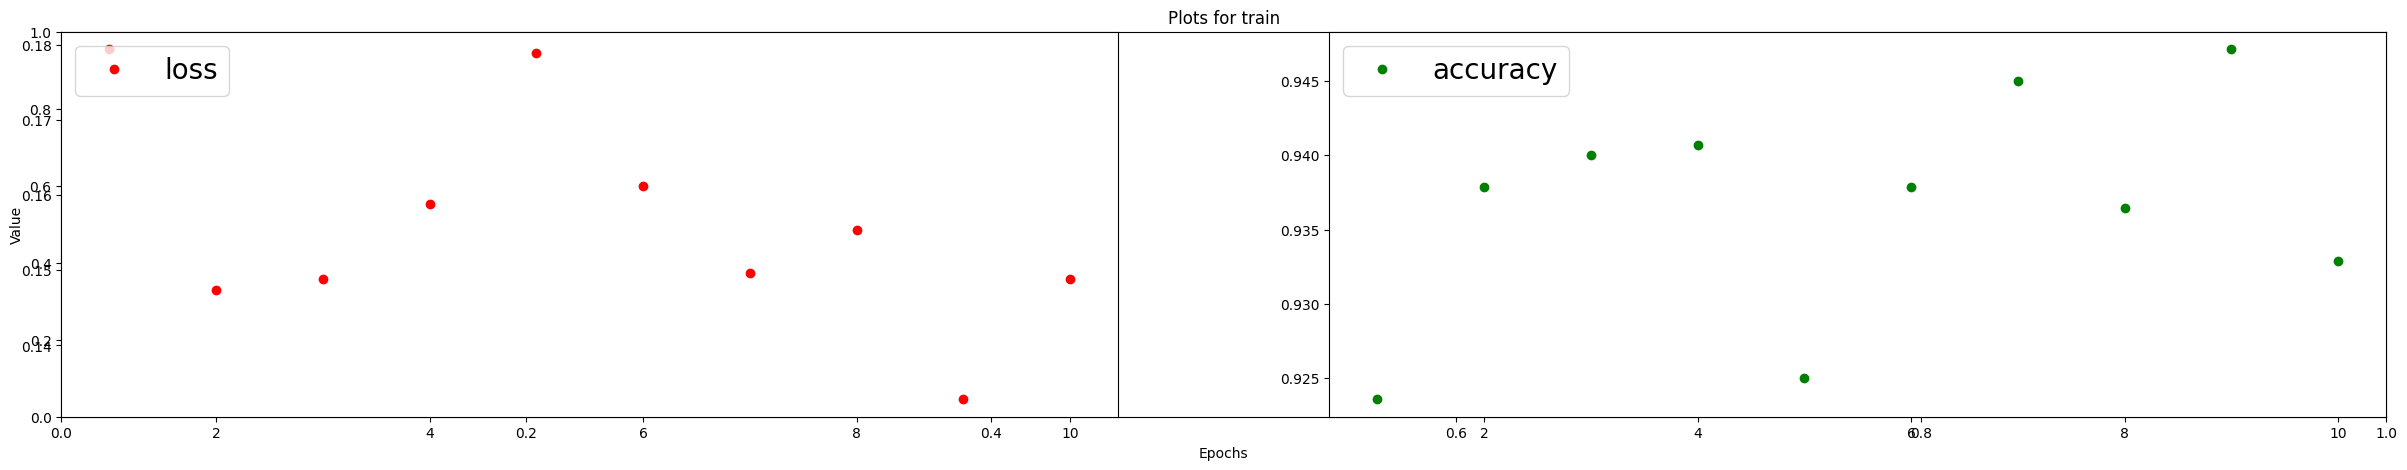

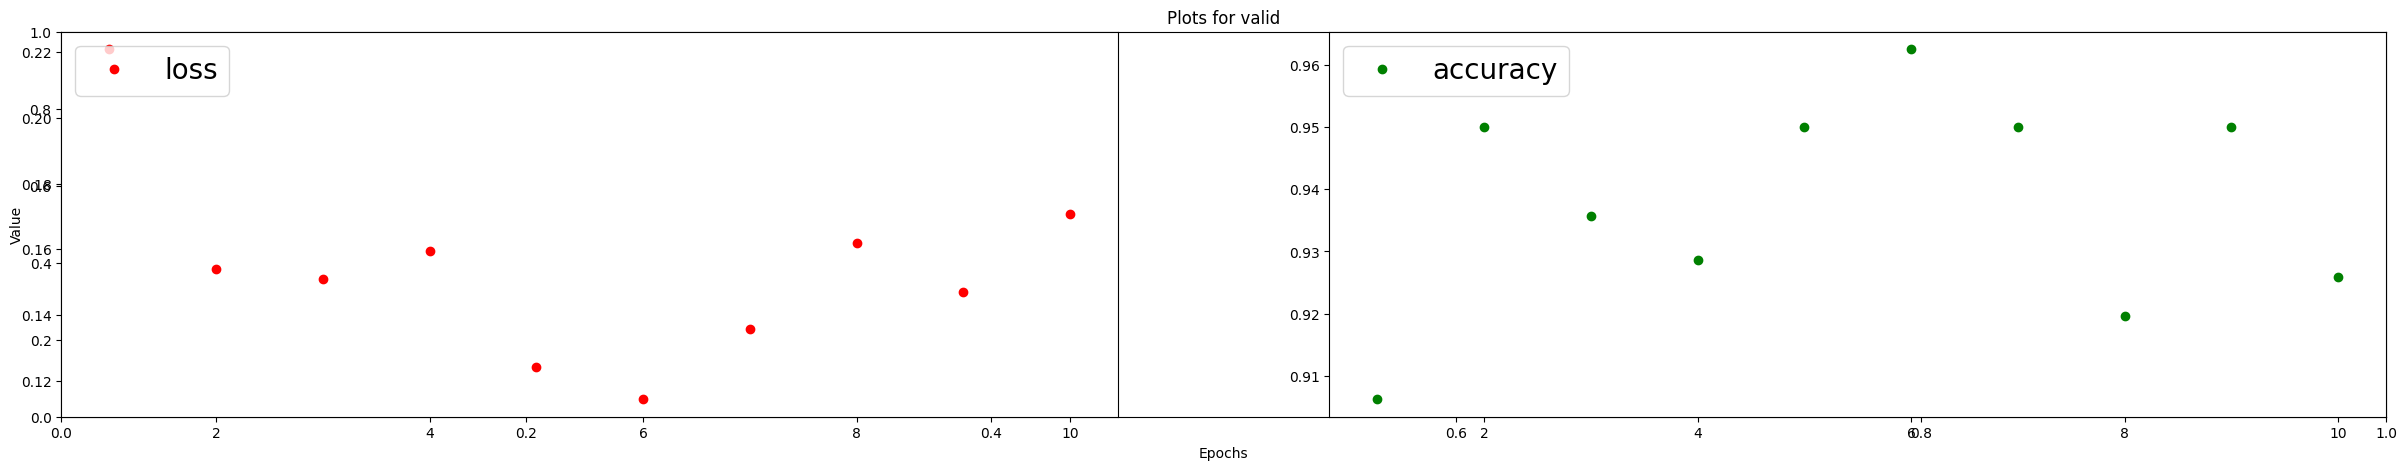

In [12]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20
Epoch : 1, train accuracy : 0.9464290142059326, train loss : 0.12208281457424164
Epoch : 1, val_accuracy : 0.956250011920929, val_loss : 0.08878011256456375
Epoch : 2, train accuracy : 0.9364290833473206, train loss : 0.15295037627220154
Epoch : 2, val_accuracy : 0.9223213791847229, val_loss : 0.16722817718982697
Epoch : 3, train accuracy : 0.9557148814201355, train loss : 0.11934484541416168
Epoch : 3, val_accuracy : 0.9374999403953552, val_loss : 0.13794276118278503
Epoch : 4, train accuracy : 0.9471433758735657, train loss : 0.11877741664648056
Epoch : 4, val_accuracy : 0.9624999165534973, val_loss : 0.09973537176847458
Epoch : 5, train accuracy : 0.9471434950828552, train loss : 0.12541715800762177
Epoch : 5, val_accuracy : 0.934821367263794, val_loss : 0.12296818196773529
Epoch : 6, train accuracy : 0.9635721445083618, train loss : 0.0996638834476471
Epoch : 6, val_accuracy : 0.9410713911056519, val_loss : 0.14604587852954865
Epoch : 7, train 

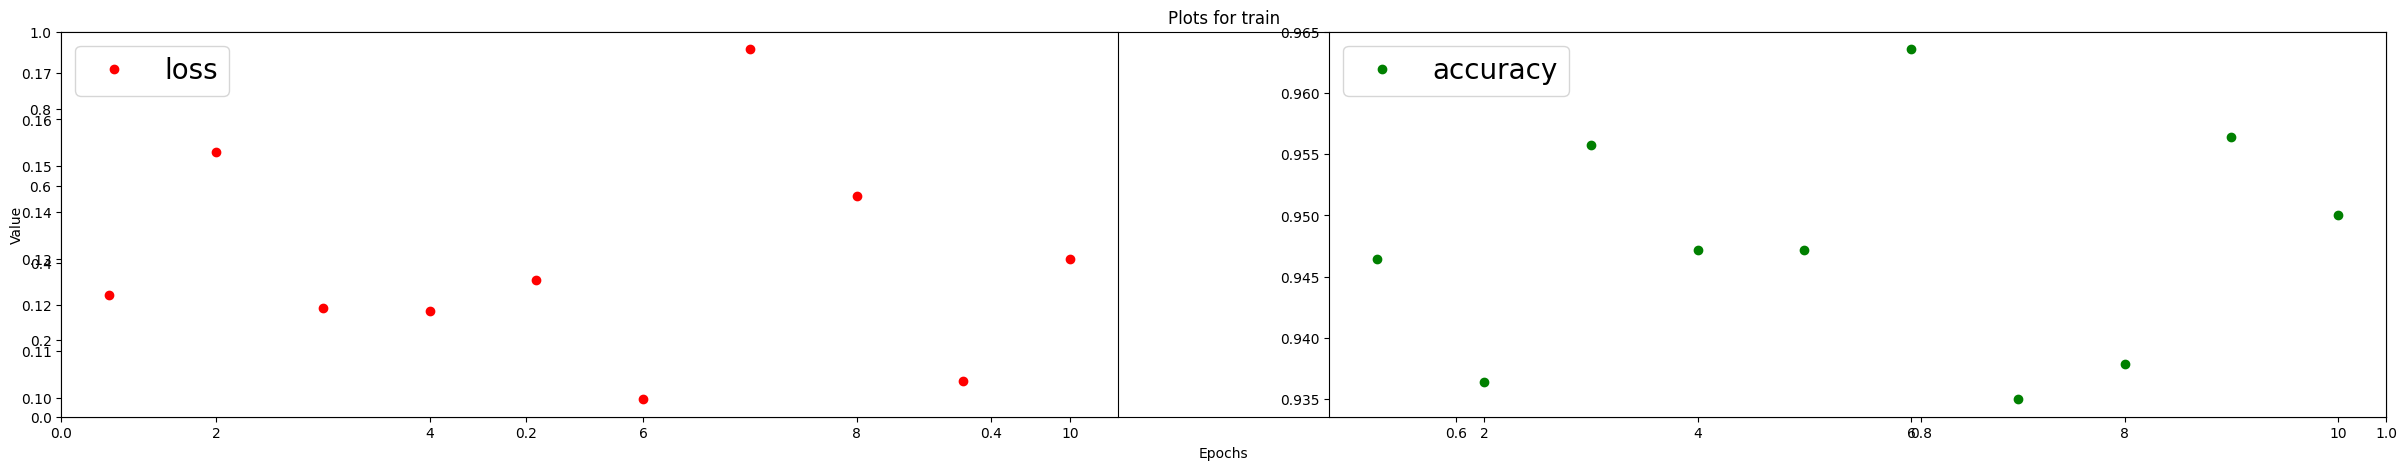

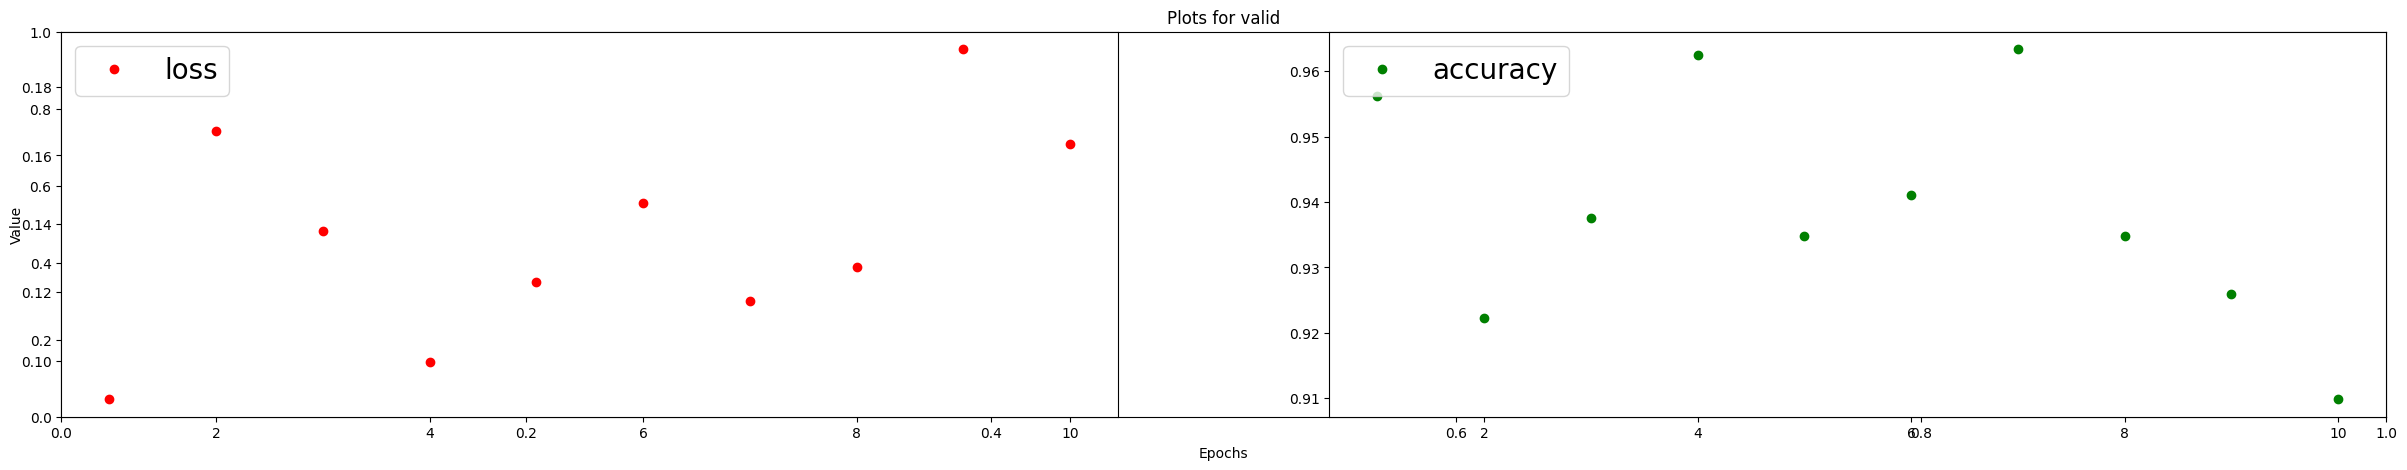

In [13]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9464290142059326, train loss : 0.12686821818351746
Epoch : 1, val_accuracy : 0.9562499523162842, val_loss : 0.11737621575593948
Epoch : 2, train accuracy : 0.9400003552436829, train loss : 0.1192299947142601
Epoch : 2, val_accuracy : 0.9258928894996643, val_loss : 0.22938311100006104
Epoch : 3, train accuracy : 0.9542862772941589, train loss : 0.11965152621269226
Epoch : 3, val_accuracy : 0.956250011920929, val_loss : 0.11180863529443741
Epoch : 4, train accuracy : 0.9371432662010193, train loss : 0.12610217928886414
Epoch : 4, val_accuracy : 0.959821343421936, val_loss : 0.10326994955539703
Epoch : 5, train accuracy : 0.9221431612968445, train loss : 0.16926103830337524
Epoch : 5, val_accuracy : 0.9624999761581421, val_loss : 0.09977702051401138
Epoch : 6, train accuracy : 0.9400005340576172, train loss : 0.14428545534610748
Epoch : 6, val_accuracy : 0.9624999761581421, val_loss : 0.08893846720457077
Epoch : 7, train 

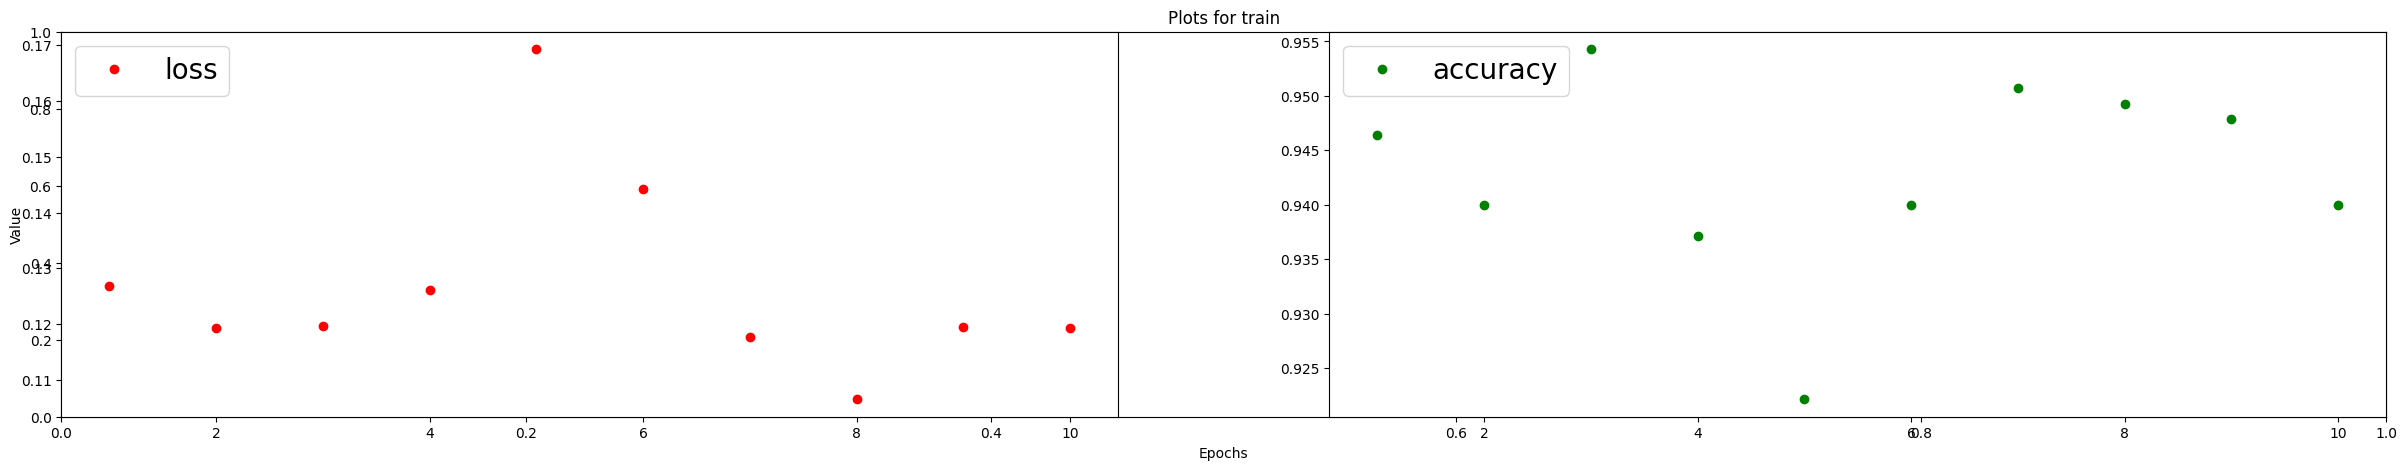

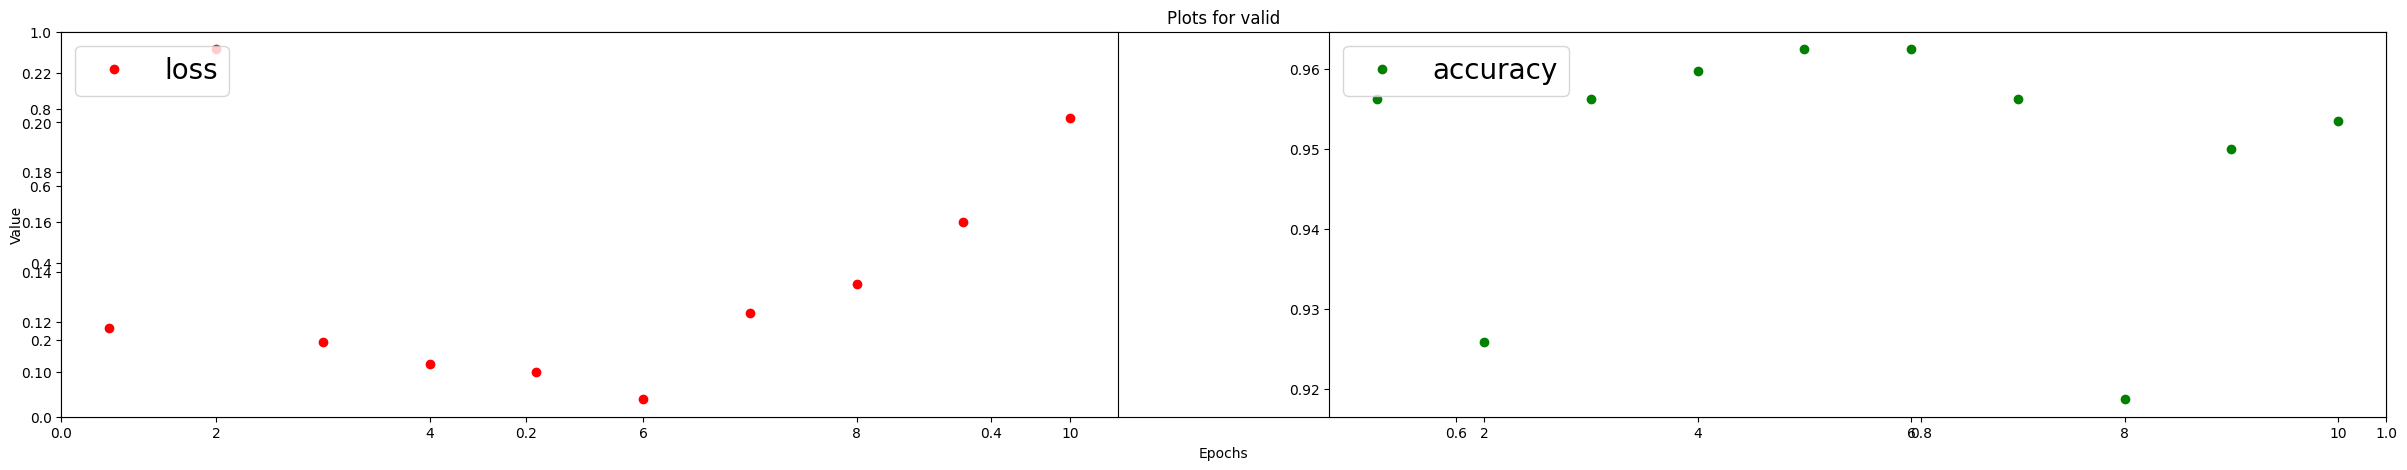

In [14]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50
Epoch : 1, train accuracy : 0.9585715532302856, train loss : 0.11193240433931351
Epoch : 1, val_accuracy : 0.9650000333786011, val_loss : 0.10508902370929718
Epoch : 2, train accuracy : 0.963884174823761, train loss : 0.08189285546541214
Epoch : 2, val_accuracy : 0.9800000190734863, val_loss : 0.06148731708526611
Epoch : 3, train accuracy : 0.9641966223716736, train loss : 0.08164089918136597
Epoch : 3, val_accuracy : 0.9449999928474426, val_loss : 0.1548008918762207
Epoch : 4, train accuracy : 0.9677680134773254, train loss : 0.08277138322591782
Epoch : 4, val_accuracy : 0.9850000143051147, val_loss : 0.06533106416463852
Epoch : 5, train accuracy : 0.9656251072883606, train loss : 0.09359229356050491
Epoch : 5, val_accuracy : 0.8399999737739563, val_loss : 0.36736735701560974
Epoch : 6, train accuracy : 0.9652233123779297, train loss : 0.09395698457956314
Epoch : 6, val_accuracy : 0.8400000333786011, val_loss : 0.5916483998298645
Epoch : 7, train a

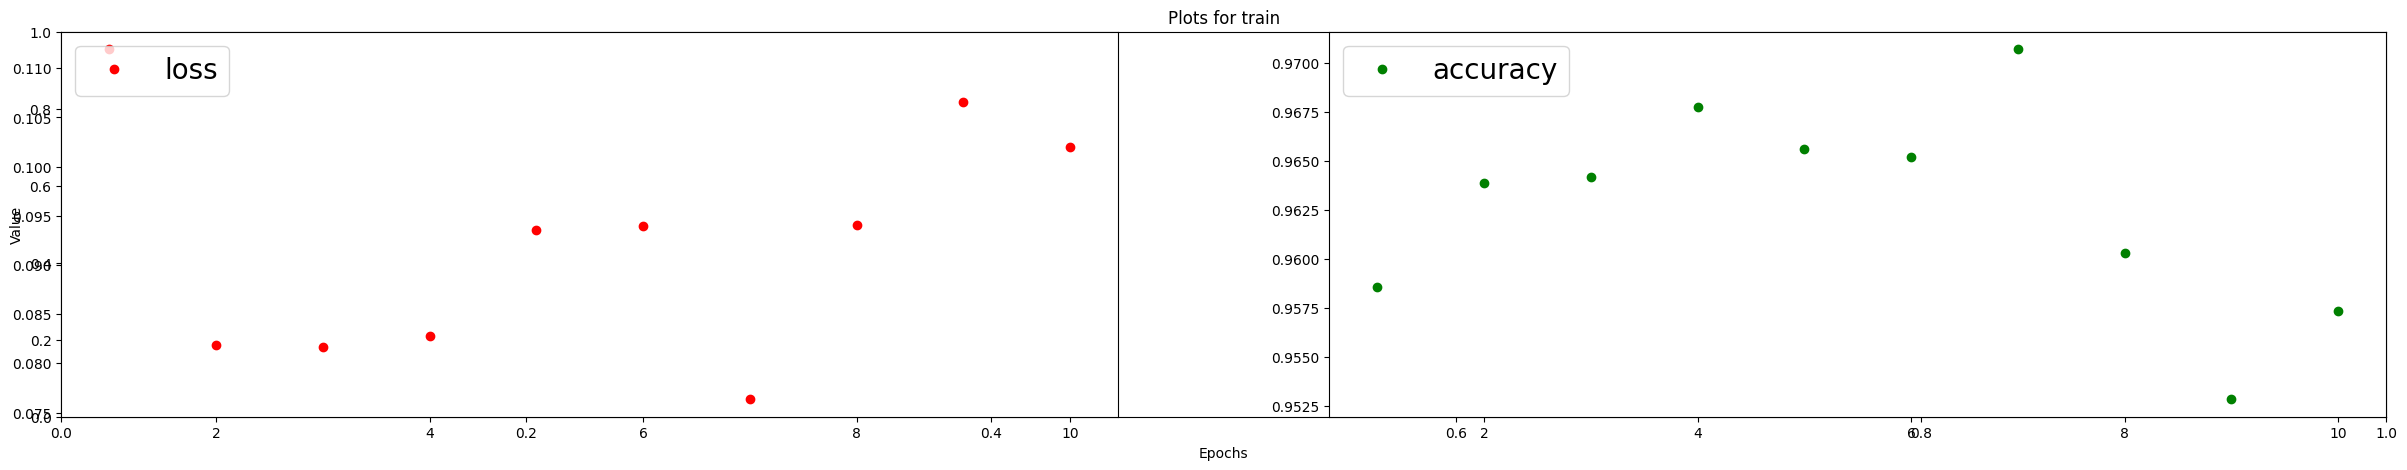

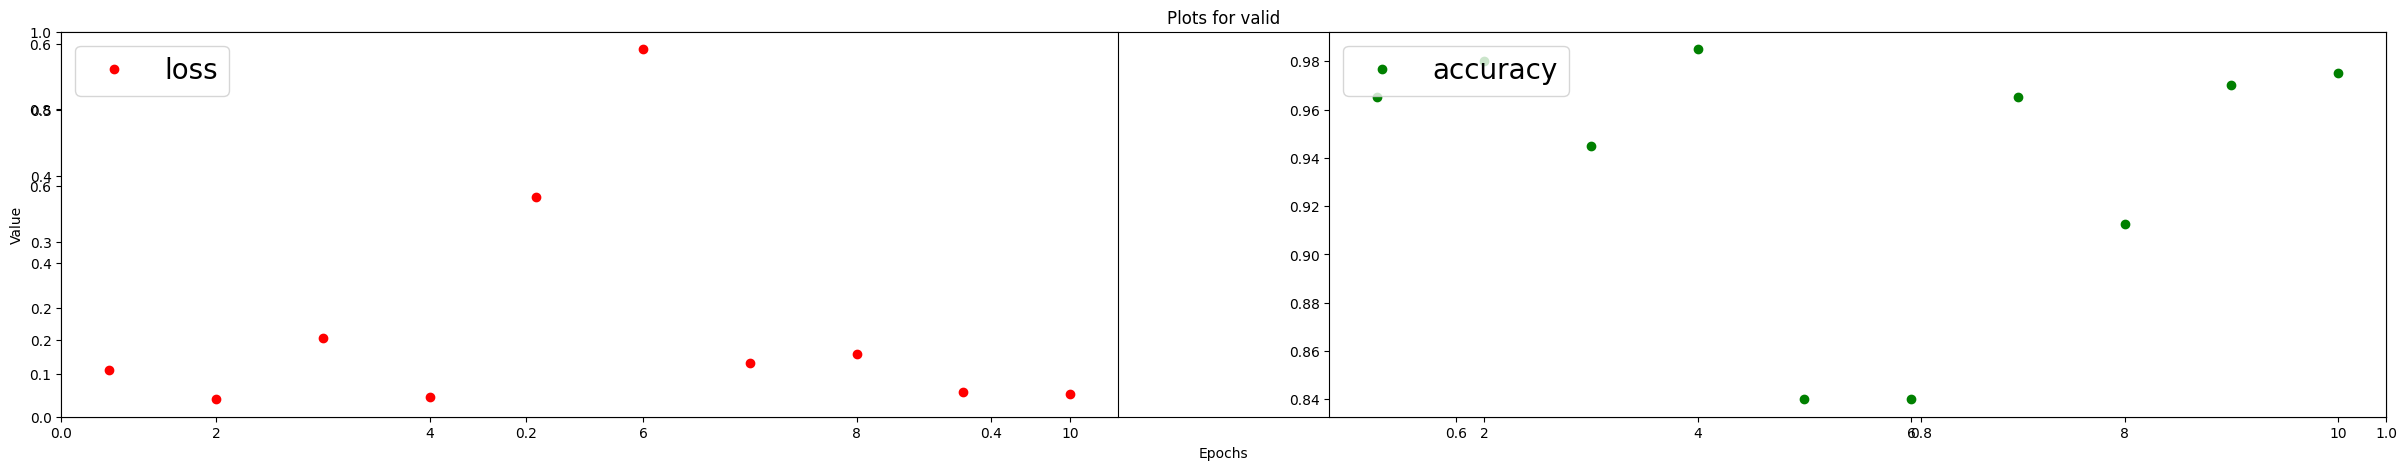

In [15]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50
Epoch : 1, train accuracy : 0.9730803370475769, train loss : 0.06767548620700836
Epoch : 1, val_accuracy : 0.7775000333786011, val_loss : 0.6334666609764099
Epoch : 2, train accuracy : 0.9670537114143372, train loss : 0.08234009146690369
Epoch : 2, val_accuracy : 0.9750000238418579, val_loss : 0.060901422053575516
Epoch : 3, train accuracy : 0.9728571772575378, train loss : 0.07177115976810455
Epoch : 3, val_accuracy : 0.9025000333786011, val_loss : 0.3374411463737488
Epoch : 4, train accuracy : 0.9585715532302856, train loss : 0.09876701980829239
Epoch : 4, val_accuracy : 0.8650000095367432, val_loss : 0.5675695538520813
Epoch : 5, train accuracy : 0.9728572964668274, train loss : 0.07283992320299149
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.08902455866336823
Epoch : 6, train accuracy : 0.9710268974304199, train loss : 0.08136440813541412
Epoch : 6, val_accuracy : 0.9175000190734863, val_loss : 0.1479157954454422
Epoch : 7, train 

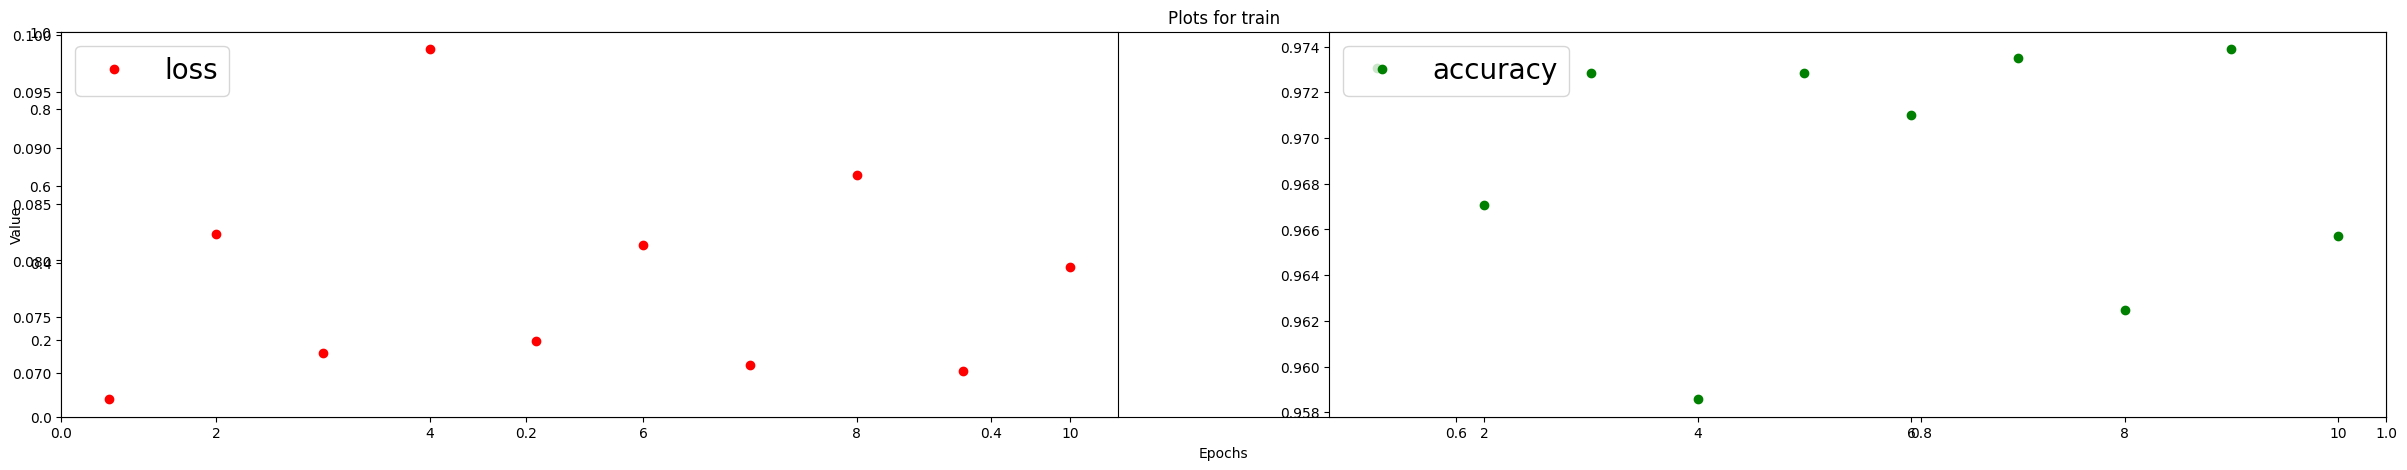

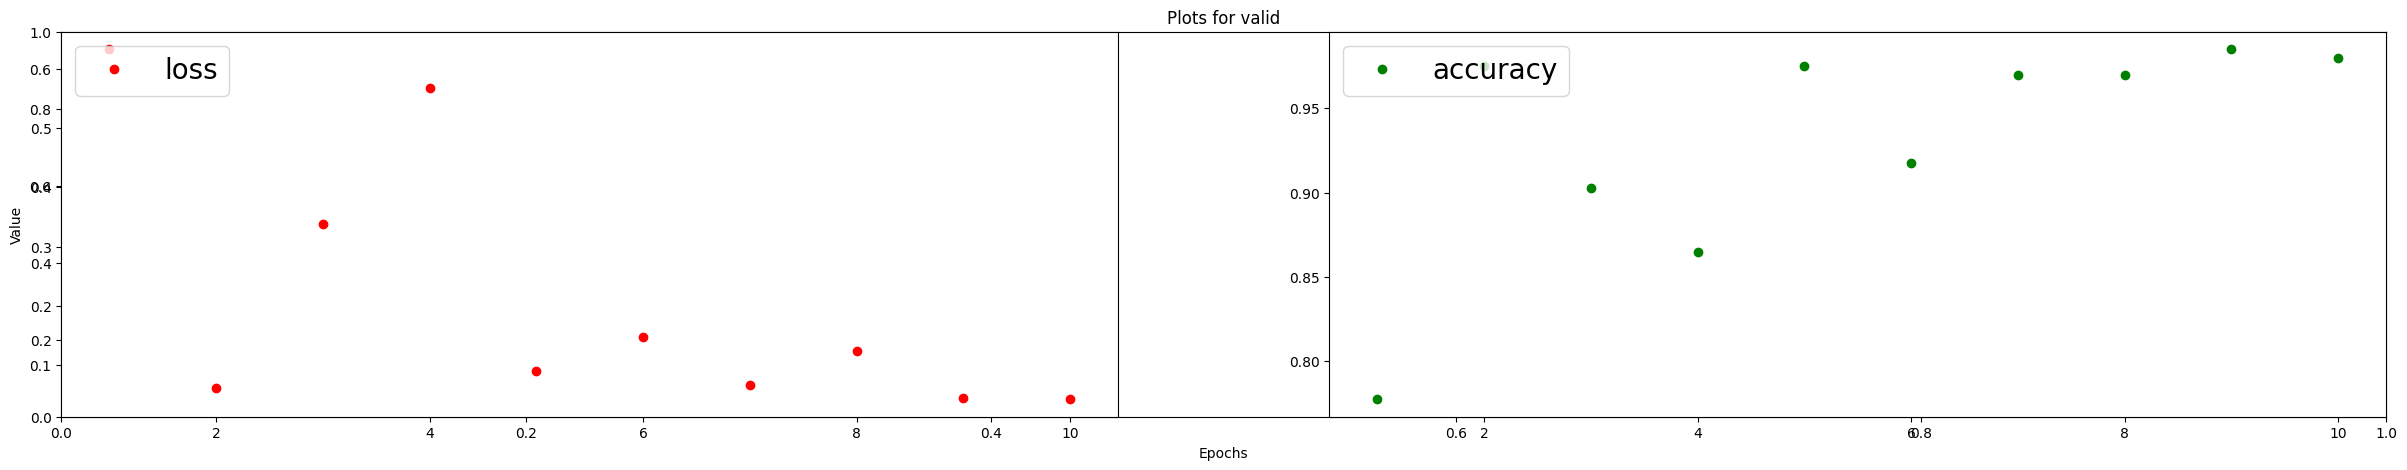

In [16]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50
Epoch : 1, train accuracy : 0.9685715436935425, train loss : 0.06470586359500885
Epoch : 1, val_accuracy : 0.8299999833106995, val_loss : 0.64087975025177
Epoch : 2, train accuracy : 0.9714286923408508, train loss : 0.08262410759925842
Epoch : 2, val_accuracy : 0.9700000286102295, val_loss : 0.08075453341007233
Epoch : 3, train accuracy : 0.9731696844100952, train loss : 0.0720246210694313
Epoch : 3, val_accuracy : 0.9850000143051147, val_loss : 0.07121026515960693
Epoch : 4, train accuracy : 0.968169629573822, train loss : 0.07955971360206604
Epoch : 4, val_accuracy : 0.9650000333786011, val_loss : 0.0982060432434082
Epoch : 5, train accuracy : 0.9595983624458313, train loss : 0.0862809494137764
Epoch : 5, val_accuracy : 0.9700000286102295, val_loss : 0.10361448675394058
Epoch : 6, train accuracy : 0.9688842296600342, train loss : 0.08387148380279541
Epoch : 6, val_accuracy : 0.9125000238418579, val_loss : 0.34744012355804443
Epoch : 7, train accu

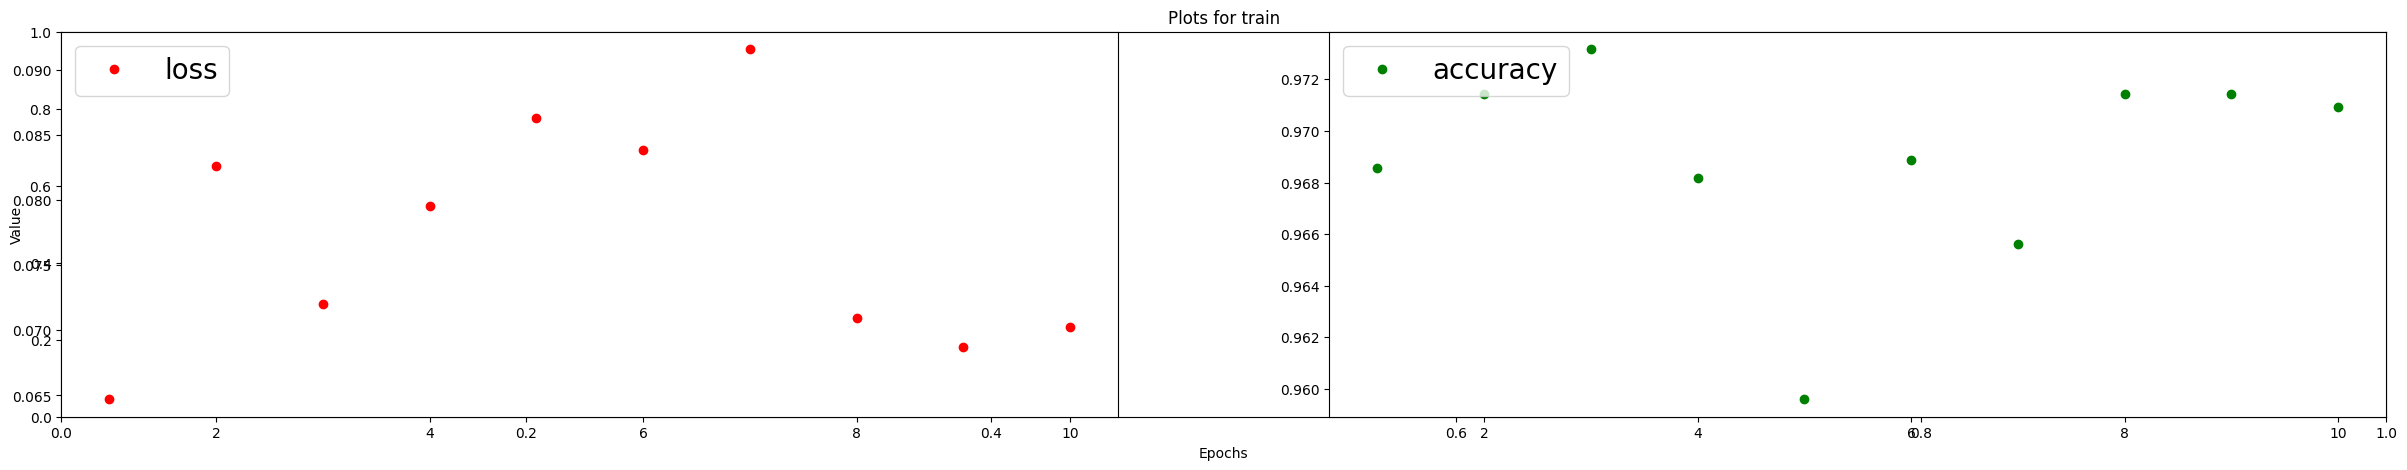

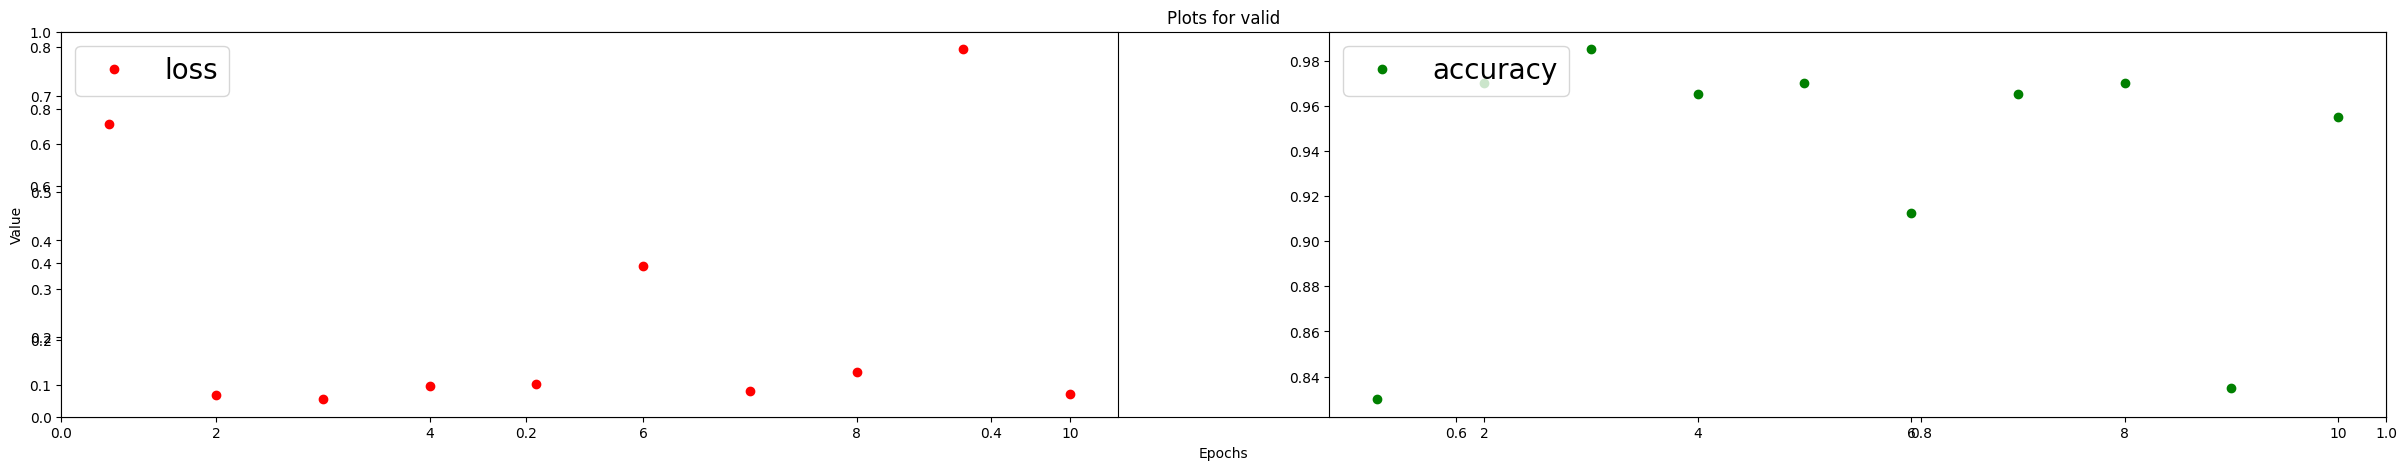

In [17]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

In [18]:
tiger_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        tiger_probs += list(zip(labels, preds_list))

idx = list(map(lambda x: x[0],tiger_probs))
prob = list(map(lambda x: x[1],tiger_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

id         label
0    1778  5.921610e-02
1    1773  1.649585e-01
2    1748  7.913418e-11
3     771  9.999998e-01
4     854  9.999837e-01
..    ...           ...
189  1771  3.462132e-04
190   783  9.999514e-01
191  1803  8.849284e-01
192   813  9.826838e-01
193  1746  3.629593e-07

[194 rows x 2 columns]

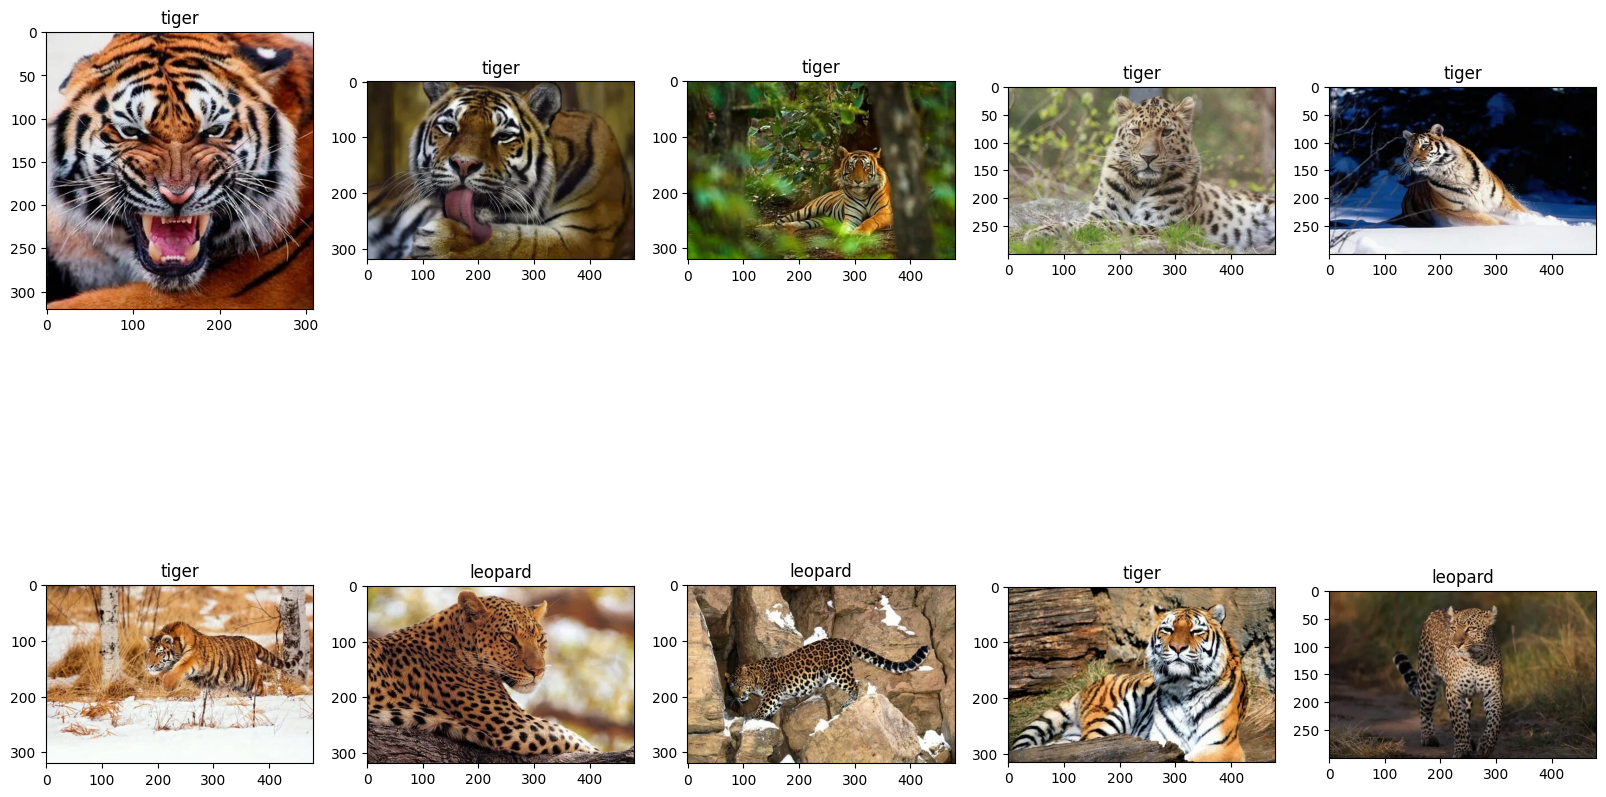

In [20]:
class_ = {0: 'leopard', 1: 'tiger'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)

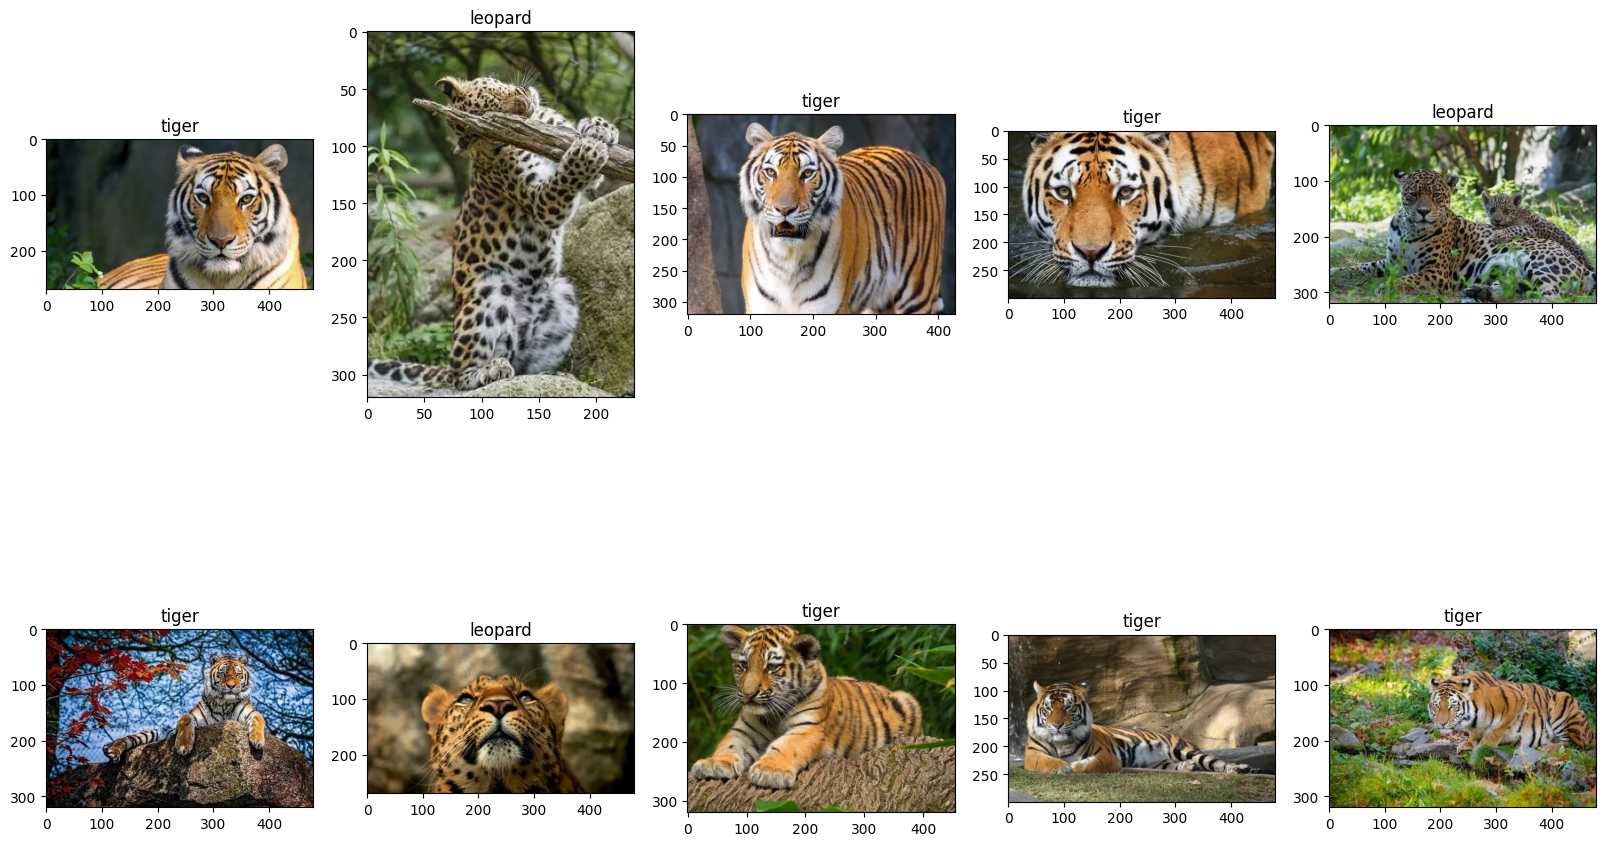

In [22]:
torch.save(model.state_dict(), 'ConvNetModel.pth')

loaded_model = ConvNet().to(device)
loaded_model.load_state_dict(torch.load('ConvNetModel.pth'))
loaded_model.eval()

leopard_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = loaded_model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        leopard_probs += list(zip(labels, preds_list))

idx = list(map(lambda x: x[0],leopard_probs))
prob = list(map(lambda x: x[1],leopard_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

class_ = {0: 'leopard', 1: 'tiger'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)